# Astronomy Application of Denoising Methodologies

In this notebook we consider an application of two empirical Bayes denoising methods to an astronomy data set, yielding Figure 6.1 from the arxiv version of the paper. Specifically, we focus on the question of inferring the latent disribution of chemical abundances for a catalog of red-clump stars.

In [1]:
from npeb.GLMixture import *
import numpy as np
import pandas as pd
import pickle
import cvxpy as cp
import matplotlib.pyplot as plt
import random
import itertools
from heapq import nlargest
from scipy.linalg import inv, sqrtm
from matplotlib.path import Path
import matplotlib.patches as patches
import scipy.stats as stats
from scipy.spatial import distance_matrix

## Set up data

Our data is taken from the Apache Point Observatory Galactic Evolution Experiment
(APOGEE) survey. We cast the data into the appropriate form in `assets/make_astronomy_dataset.ipynb`, and the results are saved in a `.pkl` file that we upload.

In [2]:
chemicals = np.load('assets/astronomy_data.pkl', allow_pickle=True)
chemicals

,O_FE_val,N_FE_val,O_FE_prec,N_FE_prec
0,0.451253,0.000488,1242.647583,3506.642822
1,0.205446,-0.019748,527.858582,1454.366577
2,0.286582,-0.012526,544.095215,1317.257568
3,0.170408,0.100237,158.037277,366.887726
4,0.220619,0.210335,316.018341,732.457886
...,...,...,...,...
1495,0.424075,-0.068805,703.502441,1953.476562
1496,0.225244,0.231816,432.391632,971.942261
1497,0.184397,0.042081,404.006744,1105.418091
1498,0.261229,0.090537,504.675446,1389.055908


In [3]:
Z = np.vstack([chemicals['O_FE_val'].values,chemicals['N_FE_val'].values]).T
Sigma = 1./np.vstack([chemicals['O_FE_prec'].values,chemicals['N_FE_prec'].values]).T
n = Z.shape[0]

In order to choose the smoothing parameter in the NPMLE, we pick a suitable quantile of the observed variances.

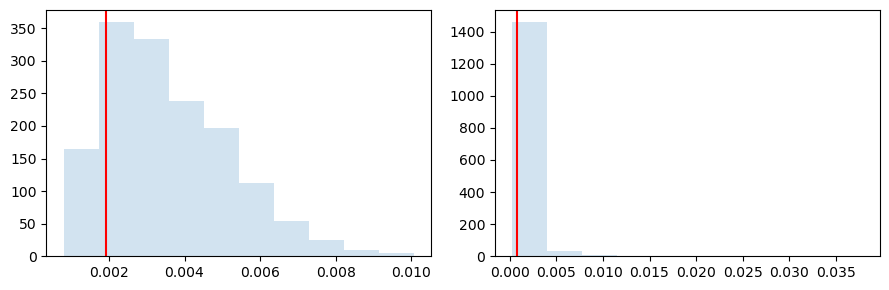

In [4]:
q_x = 0.15
q_y = 0.15
tau2_x = np.quantile(Sigma[:,0],q_x)
tau2_y = np.quantile(Sigma[:,1],q_y)

fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(9,3))

ax[0].hist(Sigma[:,0], alpha=0.2)
ax[0].axvline(tau2_x,color='red')

ax[1].hist(Sigma[:,1], alpha=0.2)
ax[1].axvline(tau2_y,color='red')

plt.tight_layout()
plt.show()

## Compute denoisers

Next, we compute the three empirical Bayes denoisers of interest for the chemistry data. We do this by using the `npeb` package to compute the smooth NPMLE via artificilly inflating the variances.

### (Unconstrained) empirical Bayes

In [5]:
Tau = np.vstack([tau2_x*np.ones(n), tau2_y*np.ones(n)]).T
eb_model = GLMixture(prec_type='diagonal')
eb = eb_model.fit(Z,1./(Sigma + Tau))

Selecting all data points as atoms: done.
Computing kernel matrix: done.
Solving for discretized NPMLE: done.


In [6]:
post_means = eb_model.posterior_mean(Z, 1./(Sigma + Tau))
eb = np.zeros_like(Z)
eb[:,0] = (1./tau2_x) * Z[:,0] / (1./tau2_x + 1./Sigma[:,0]) + (1./Sigma[:,0]) * post_means[:,0] / (1./tau2_x + 1./Sigma[:,0])
eb[:,1] = (1./tau2_y) * Z[:,1] / (1./tau2_y + 1./Sigma[:,1]) + (1./Sigma[:,1]) * post_means[:,1] / (1./tau2_y + 1./Sigma[:,1])

## Variance-constrained empirical Bayes

In [7]:
eb_mean = np.mean(eb,axis=0)
M_hat = (eb-eb_mean).T@(eb-eb_mean)/n
at, wt = eb_model.get_params()
mu_hat = np.sum(at * wt.reshape(-1,1), axis=0)
A_hat = np.diag([tau2_x,tau2_y]) + (at - mu_hat).T @ np.diag(wt) @ (at - mu_hat)
transport_hat = inv(sqrtm(M_hat))@sqrtm(sqrtm(M_hat)@A_hat@sqrtm(M_hat))@inv(sqrtm(M_hat))
emvcb = (eb - eb_mean)@transport_hat + mu_hat

## Distribution-constrained empirical Bayes

In [8]:
k = 250  # grid resolution
K = 3000 # subsampling

Eta_x = np.linspace(-0.1,0.6,k)
Eta_y = np.linspace(-0.1,0.4,k)
Eta = np.array(list(itertools.product(Eta_x,Eta_y)))
Eta = np.vstack([Eta, at])

m = len(wt)
Eta_wt = np.zeros(k**2 + len(at))
for i in range(m): # TODO: vectorize this step
    rv = stats.multivariate_normal(mean=at[i,:], cov=[tau2_x, tau2_y])
    probs = rv.pdf(Eta)
    Eta_wt += probs * wt[i] / np.sum(probs)

inds = np.random.choice(np.arange(k**2+m), size=K, replace=False, p=Eta_wt)
Eta = Eta[inds]
Eta_wt = Eta_wt[inds]/np.sum(Eta_wt[inds])

In [9]:
pi = cp.Variable((n,K))
C_hat = distance_matrix(eb, Eta)**2
objv = cp.Minimize(cp.sum(cp.multiply(C_hat, pi)))
emdcb = np.zeros((n,2))
cstr = [pi >= 0, cp.sum(pi) == 1,
        cp.sum(pi, axis=1) == np.ones(n)/n,
        cp.sum(pi, axis=0) == Eta_wt]
problem = cp.Problem(objv,cstr)
problem.solve(solver='MOSEK',verbose=False)
pi_opt = pi.value
for i in range(n):
    emdcb[i,:] = (pi_opt[i,:].reshape(1,-1)@Eta)/np.sum(pi_opt[i,:])

## Plotting

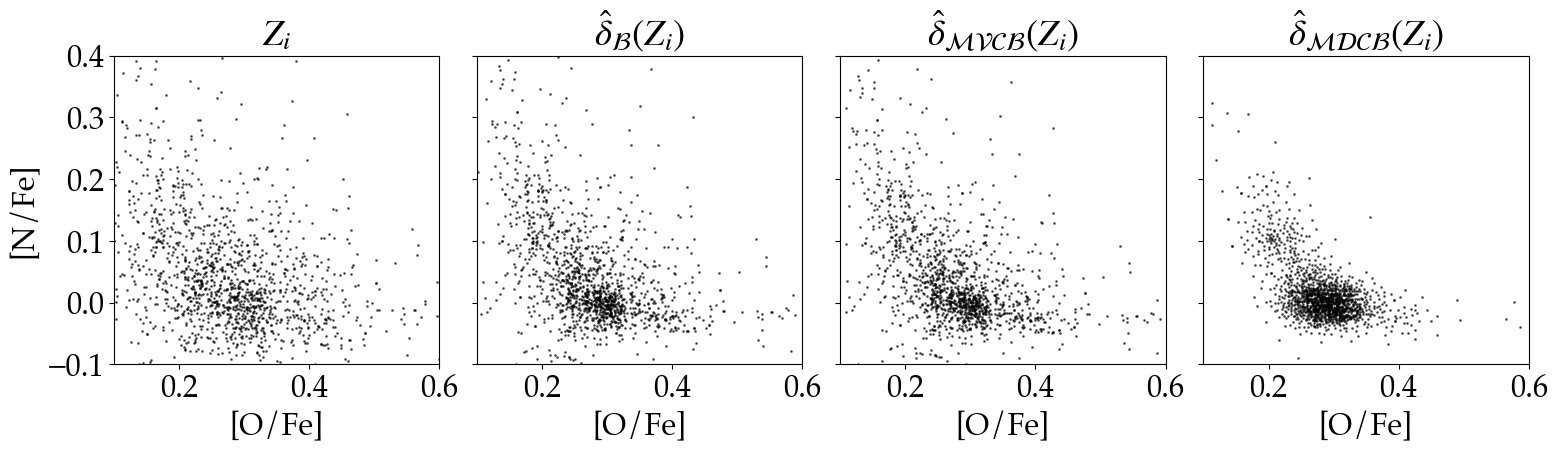

In [11]:
plt.rcParams.update({'font.size': 22,
                     'mathtext.fontset': 'stix',
                     'font.family': 'serif',
                     'font.serif':'Palatino'})

fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16,5))

xmin, xmax = 0.1, 0.6,
ymin, ymax = -0.1, 0.4

ax[0].scatter(Z[:,0],Z[:,1], s=1, alpha = 0.55, color='black')
ax[0].set_title('$Z_i$')
#ax[0].grid()

ax[1].scatter(eb[:,0],eb[:,1], s=1, alpha = 0.55, color='black')
ax[1].set_title('$\\hat{\\delta}_{\\mathcal{B}}(Z_i)$')
#ax[1].grid()

ax[2].scatter(emvcb[:,0],emvcb[:,1], s=1, alpha = 0.55, color='black')
ax[2].set_title('$\\hat{\\delta}_{\\mathcal{MVCB}}(Z_i)$')
#ax[2].grid()

ax[3].scatter(emdcb[:,0],emdcb[:,1], s=1, alpha = 0.55, color='black')
ax[3].set_title('$\\hat{\\delta}_{\\mathcal{MDCB}}(Z_i)$')
#ax[3].grid()

ax[0].set_xlabel('[O/Fe]')
ax[1].set_xlabel('[O/Fe]')
ax[2].set_xlabel('[O/Fe]')
ax[3].set_xlabel('[O/Fe]')
ax[0].set_ylabel('[N/Fe]')

plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.savefig('astronomy.pdf')
plt.savefig('astronomy.png')
plt.show()